**DATA DIRI**


Nama : Alifia Feiling Asmoro Siwi

Username : alifiafas

IDCAMP : Machine Learning Developer

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [3]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout
tf.keras.backend.set_floatx('float64')
from sklearn.model_selection import train_test_split
cuaca = pd.read_csv('/content/weather.csv')
cuaca

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Country/Region,Province/State,time,summary,icon,sunriseTime,sunsetTime,moonPhase,precipIntensity,precipIntensityMax,precipIntensityMaxTime,precipProbability,precipType,temperatureHigh,temperatureHighTime,temperatureLow,temperatureLowTime,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,dewPoint,humidity,pressure,windSpeed,windGust,windGustTime,windBearing,cloudCover,uvIndex,uvIndexTime,visibility,ozone,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,Lat,Long,precipAccumulation
0,0,Afghanistan,NaN,2019-12-31,Rain (with a chance of 1–3 in. of snow) until ...,rain,1.577847e+09,1.577883e+09,0.20,0.0156,0.1515,1.577902e+09,0.71,rain,48.36,1577864700,32.13,1577922180,47.86,1577864700,29.04,1577921940,23.88,0.60,1019.1,2.56,6.60,1577891880,39,0.99,2,1577864880,5.534,372.6,32.96,1577827140,48.36,1577864700,30.51,1577835720,47.86,1577864700,33.0,65.0,NaN
1,1,Afghanistan,NaN,2020-01-01,Light rain throughout the day.,rain,1.577933e+09,1.577969e+09,0.23,0.0235,0.0985,1.577907e+09,0.95,rain,40.42,1577951460,28.90,1578020400,40.08,1577951220,26.27,1578020400,33.61,0.90,1021.2,2.06,7.08,1577961240,163,0.99,2,1577951280,1.192,330.2,32.33,1577918820,40.42,1577951460,29.84,1577919420,40.08,1577951220,33.0,65.0,NaN
2,2,Afghanistan,NaN,2020-01-02,Clear throughout the day.,rain,1.578019e+09,1.578056e+09,0.26,0.0016,0.0062,1.578010e+09,0.25,rain,46.53,1578038340,28.80,1578106320,46.03,1578038340,26.96,1578093240,29.86,0.76,1022.7,2.45,4.78,1578042840,20,0.22,3,1578037860,9.957,320.3,28.90,1578020400,46.53,1578038340,26.27,1578020400,46.03,1578038340,33.0,65.0,NaN
3,3,Afghanistan,NaN,2020-01-03,Partly cloudy throughout the day.,partly-cloudy-day,1.578106e+09,1.578142e+09,0.30,0.0003,0.0012,1.578158e+09,0.14,rain,45.77,1578124500,32.84,1578193080,45.35,1578124260,33.33,1578193080,26.61,0.69,1021.9,2.95,5.83,1578139740,19,0.32,3,1578122520,10.000,309.6,28.80,1578106320,45.77,1578124500,26.96,1578093240,45.35,1578124260,33.0,65.0,NaN
4,4,Afghanistan,NaN,2020-01-04,Light rain throughout the day.,rain,1.578192e+09,1.578228e+09,0.33,0.0145,0.0310,1.578200e+09,0.83,rain,40.84,1578222000,37.25,1578279840,40.34,1578222000,37.74,1578279840,33.14,0.88,1016.1,1.98,6.14,1578226200,75,1.00,2,1578210360,4.142,308.2,32.84,1578193080,40.84,1578222000,33.33,1578193080,40.34,1578222000,33.0,65.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17218,17218,Montenegro,NaN,2020-03-22,Mostly cloudy throughout the day.,rain,1.584938e+09,1.584983e+09,0.98,0.0017,0.0054,1.584932e+09,0.29,rain,43.03,1584961140,28.54,1585029900,37.92,1584961140,24.58,1585029600,25.51,0.62,1018.3,7.95,19.31,1584918000,21,0.82,4,1584961860,9.727,363.3,30.89,1585000800,43.03,1584961140,25.36,1585000800,37.92,1584961140,42.5,19.3,NaN
17219,17219,Montenegro,NaN,2020-03-23,Drizzle in the morning and afternoon.,rain,1.585025e+09,1.585069e+09,0.01,0.0083,0.0169,1.585074e+09,0.87,rain,41.94,1585058340,27.44,1585113960,39.38,1585064820,21.37,1585114080,26.50,0.74,1017.8,3.34,13.12,1585004400,57,0.78,2,1585046460,8.363,423.7,28.54,1585029900,41.94,1585058340,24.58,1585029600,39.38,1585064820,42.5,19.3,NaN
17220,17220,Montenegro,NaN,2020-03-24,Mostly cloudy throughout the day.,partly-cloudy-day,1.585111e+09,1.585156e+09,0.04,0.0003,0.0017,1.585091e+09,0.18,rain,50.37,1585144140,37.48,1585193280,47.30,1585144260,32.12,1585192980,30.87,0.74,1017.7,5.99,18.47,1585164000,29,0.61,3,1585133160,10.000,388.2,27.44,1585113960,50.37,1585144140,21.37,1585114080,47.30,1585144260,42.5,19.3,NaN
17221,17221,Montenegro,NaN,2020-03-25,Mostly cloudy throughout the day.,rain,1.585197e+09,1.585242e+09,0.07,0.0013,0.0088,1.585192e+09,0.39,rain,55.97,1585227840,42.58,1585287300,55.47,1585227840,39.63,15852573

In [4]:
cuaca.values.shape

(17223, 45)

In [5]:
cuaca.isna().sum()

Unnamed: 0                         0
Country/Region                     0
Province/State                 10615
time                               0
summary                            3
icon                               0
sunriseTime                       25
sunsetTime                        25
moonPhase                          0
precipIntensity                    0
precipIntensityMax                 0
precipIntensityMaxTime            68
precipProbability                  0
precipType                      1527
temperatureHigh                    0
temperatureHighTime                0
temperatureLow                     0
temperatureLowTime                 0
apparentTemperatureHigh            0
apparentTemperatureHighTime        0
apparentTemperatureLow             0
apparentTemperatureLowTime         0
dewPoint                           0
humidity                           0
pressure                           0
windSpeed                          0
windGust                           0
w

In [6]:
cuaca['meanku'] = cuaca[['temperatureHigh', 'temperatureLow']].mean(axis=1)
cuaca

,Unnamed: 0,Country/Region,Province/State,time,summary,icon,sunriseTime,sunsetTime,moonPhase,precipIntensity,precipIntensityMax,precipIntensityMaxTime,precipProbability,precipType,temperatureHigh,temperatureHighTime,temperatureLow,temperatureLowTime,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,dewPoint,humidity,pressure,windSpeed,windGust,windGustTime,windBearing,cloudCover,uvIndex,uvIndexTime,visibility,ozone,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,Lat,Long,precipAccumulation,meanku
0,0,Afghanistan,NaN,2019-12-31,Rain (with a chance of 1–3 in. of snow) until ...,rain,1.577847e+09,1.577883e+09,0.20,0.0156,0.1515,1.577902e+09,0.71,rain,48.36,1577864700,32.13,1577922180,47.86,1577864700,29.04,1577921940,23.88,0.60,1019.1,2.56,6.60,1577891880,39,0.99,2,1577864880,5.534,372.6,32.96,1577827140,48.36,1577864700,30.51,1577835720,47.86,1577864700,33.0,65.0,NaN,40.245
1,1,Afghanistan,NaN,2020-01-01,Light rain throughout the day.,rain,1.577933e+09,1.577969e+09,0.23,0.0235,0.0985,1.577907e+09,0.95,rain,40.42,1577951460,28.90,1578020400,40.08,1577951220,26.27,1578020400,33.61,0.90,1021.2,2.06,7.08,1577961240,163,0.99,2,1577951280,1.192,330.2,32.33,1577918820,40.42,1577951460,29.84,1577919420,40.08,1577951220,33.0,65.0,NaN,34.660
2,2,Afghanistan,NaN,2020-01-02,Clear throughout the day.,rain,1.578019e+09,1.578056e+09,0.26,0.0016,0.0062,1.578010e+09,0.25,rain,46.53,1578038340,28.80,1578106320,46.03,1578038340,26.96,1578093240,29.86,0.76,1022.7,2.45,4.78,1578042840,20,0.22,3,1578037860,9.957,320.3,28.90,1578020400,46.53,1578038340,26.27,1578020400,46.03,1578038340,33.0,65.0,NaN,37.665
3,3,Afghanistan,NaN,2020-01-03,Partly cloudy throughout the day.,partly-cloudy-day,1.578106e+09,1.578142e+09,0.30,0.0003,0.0012,1.578158e+09,0.14,rain,45.77,1578124500,32.84,1578193080,45.35,1578124260,33.33,1578193080,26.61,0.69,1021.9,2.95,5.83,1578139740,19,0.32,3,1578122520,10.000,309.6,28.80,1578106320,45.77,1578124500,26.96,1578093240,45.35,1578124260,33.0,65.0,NaN,39.305
4,4,Afghanistan,NaN,2020-01-04,Light rain throughout the day.,rain,1.578192e+09,1.578228e+09,0.33,0.0145,0.0310,1.578200e+09,0.83,rain,40.84,1578222000,37.25,1578279840,40.34,1578222000,37.74,1578279840,33.14,0.88,1016.1,1.98,6.14,1578226200,75,1.00,2,1578210360,4.142,308.2,32.84,1578193080,40.84,1578222000,33.33,1578193080,40.34,1578222000,33.0,65.0,NaN,39.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17218,17218,Montenegro,NaN,2020-03-22,Mostly cloudy throughout the day.,rain,1.584938e+09,1.584983e+09,0.98,0.0017,0.0054,1.584932e+09,0.29,rain,43.03,1584961140,28.54,1585029900,37.92,1584961140,24.58,1585029600,25.51,0.62,1018.3,7.95,19.31,1584918000,21,0.82,4,1584961860,9.727,363.3,30.89,1585000800,43.03,1584961140,25.36,1585000800,37.92,1584961140,42.5,19.3,NaN,35.785
17219,17219,Montenegro,NaN,2020-03-23,Drizzle in the morning and afternoon.,rain,1.585025e+09,1.585069e+09,0.01,0.0083,0.0169,1.585074e+09,0.87,rain,41.94,1585058340,27.44,1585113960,39.38,1585064820,21.37,1585114080,26.50,0.74,1017.8,3.34,13.12,1585004400,57,0.78,2,1585046460,8.363,423.7,28.54,1585029900,41.94,1585058340,24.58,1585029600,39.38,1585064820,42.5,19.3,NaN,34.690
17220,17220,Montenegro,NaN,2020-03-24,Mostly cloudy throughout the day.,partly-cloudy-day,1.585111e+09,1.585156e+09,0.04,0.0003,0.0017,1.585091e+09,0.18,rain,50.37,1585144140,37.48,1585193280,47.30,1585144260,32.12,1585192980,30.87,0.74,1017.7,5.99,18.47,1585164000,29,0.61,3,1585133160,10.000,388.2,27.44,1585113960,50.37,1585144140,21.37,1585114080,47.30,1585144260,42.5,19.3,NaN,43.925
17221,17221,Montenegro,NaN,2020-03-25,Mostly cloudy throughout the day.,rain,1.585197e+09,1.585242e+09,0.07,0.0013,0.0088,1.585192e+09,0.39,rai

In [7]:
tanggal = cuaca['time'].values
temperatur = cuaca['meanku'].values

In [8]:
x_train, x_valid, y_train, y_valid = train_test_split(temperatur, tanggal, train_size=0.8, test_size = 0.2, shuffle = False )

In [9]:
print('Total Data Train : ',len(x_train))
print('Total Data Validation : ',len(x_valid))

Total Data Train :  13778
Total Data Validation :  3445


In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [11]:
train_set = windowed_dataset(x_train, window_size=64, batch_size=200, shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=64, batch_size=200, shuffle_buffer=1000)

model = Sequential([
    Bidirectional(LSTM(60, return_sequences=True)),
    Bidirectional(LSTM(60)),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1),
])


In [12]:
Mae = (cuaca['meanku'].max() - cuaca['meanku'].min()) * 10/100
print(Mae)

16.131500000000003


In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<16.3 and logs.get('val_mae')<16.3):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=6, validation_data = val_set, callbacks=[callbacks])

Epoch 1/6
69/69 [==============================] - 84s 1s/step - loss: 54.9852 - mae: 55.4844 - val_loss: 52.9412 - val_mae: 53.4412
Epoch 2/6
69/69 [==============================] - 72s 1s/step - loss: 53.1145 - mae: 53.6139 - val_loss: 50.2098 - val_mae: 50.7096
Epoch 3/6
69/69 [==============================] - 72s 1s/step - loss: 48.3539 - mae: 48.8530 - val_loss: 41.0779 - val_mae: 41.5765
Epoch 4/6
69/69 [==============================] - 73s 1s/step - loss: 29.2946 - mae: 29.7915 - val_loss: 16.0448 - val_mae: 16.5401
Epoch 5/6
69/69 [==============================] - 75s 1s/step - loss: 17.9114 - mae: 18.4074 - val_loss: 15.8126 - val_mae: 16.3091
Epoch 6/6
69/69 [==============================] - 73s 1s/step - loss: 12.1504 - mae: 12.6418 - val_loss: 6.4797 - val_mae: 6.9561

MAE dari model < 10% skala data


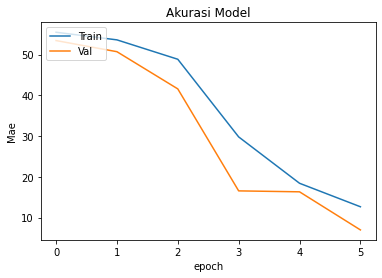

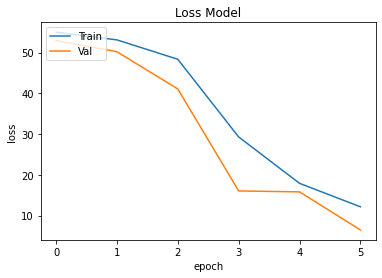

In [15]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### **Lampiran DATA DIRI di dicoding**

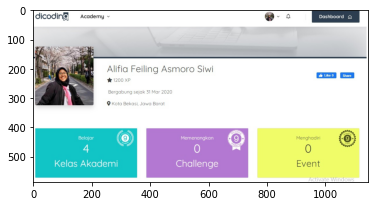

In [16]:
import matplotlib.image as mpimg
img = mpimg.imread('/content/Data diri Alifia Feiling.jpg')
imgplot = plt.imshow(img)
plt.show()